In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from scipy.spatial.distance import pdist, squareform, cdist
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

# 1. Dataset Preparation

## 1.1 Loading Dataset

In [2]:
dataset = pd.read_csv("data/final_dataset.csv")
print("Shape of dataset:", dataset.shape)
dataset.head()

Shape of dataset: (239381, 74)


,date,year,populous_city,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,...,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,month_x,month_y
0,771.0,2015.0,1,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,False,5.000000e-01,-0.866025
1,1491.0,2017.0,0,41.6645,-78.7856,62.0,62.0,62.0,0.0,1.0,...,False,False,False,False,False,False,False,False,8.660254e-01,-0.500000
2,1131.0,2016.0,1,42.4190,-83.0393,28.0,31.0,37.0,0.0,0.0,...,False,False,False,False,False,False,False,False,-5.000000e-01,0.866025
3,1132.0,2016.0,1,38.9030,-76.9820,21.0,21.0,21.0,0.0,1.0,...,False,False,False,False,False,False,False,False,-8.660254e-01,0.500000
4,770.0,2015.0,0,40.4621,-80.0308,2.0,20.0,26.0,0.0,1.0,...,False,False,False,False,False,False,False,False,1.224647e-16,-1.000000


In [3]:
print("There are NaN values:", dataset.isnull().values.any())

There are NaN values: False


In [4]:
print(dataset.columns)

Index(['date', 'year', 'populous_city', 'latitude', 'longitude',
       'min_age_participants', 'avg_age_participants', 'max_age_participants',
       'teen_ratio', 'adults_ratio', 'males_ratio', 'killed_ratio',
       'injured_ratio', 'arrested_ratio', 'n_participants',
       'povertyPercentage', 'party', 'totalvotes', 'republicans_ratio',
       'democrats_ratio', 'state_population', 'state_Alabama', 'state_Alaska',
       'state_Arizona', 'state_Arkansas', 'state_California', 'state_Colorado',
       'state_Connecticut', 'state_Delaware', 'state_District of Columbia',
       'state_Florida', 'state_Georgia', 'state_Hawaii', 'state_Idaho',
       'state_Illinois', 'state_Indiana', 'state_Iowa', 'state_Kansas',
       'state_Kentucky', 'state_Louisiana', 'state_Maine', 'state_Maryland',
       'state_Massachusetts', 'state_Michigan', 'state_Minnesota',
       'state_Mississippi', 'state_Missouri', 'state_Montana',
       'state_Nebraska', 'state_Nevada', 'state_New Hampshire',
      

## 1.2 Outlier detection

In [5]:
def return_whiskers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_whisker = q1 - 1.5 * iqr
    upper_whisker = q3 + 1.5 * iqr
    return lower_whisker, upper_whisker

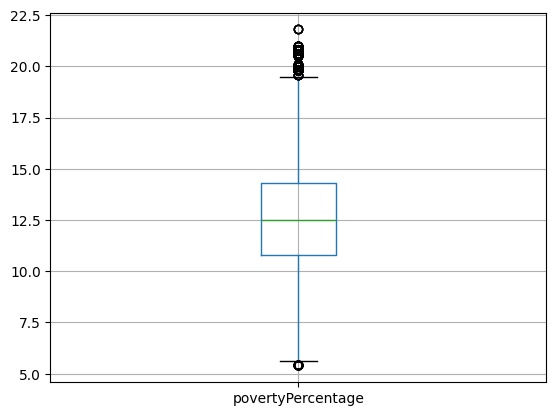

In [6]:
boxplot = dataset.boxplot(column=['povertyPercentage'])
plt.show()

In [7]:
lower_whisker_poverty, upper_whisker_poverty = return_whiskers(dataset, 'povertyPercentage')
print("Amount of outliers in povertyPercentage:", dataset[(dataset['povertyPercentage'] < lower_whisker_poverty) | (dataset['povertyPercentage'] > upper_whisker_poverty)].shape[0])

Amount of outliers in povertyPercentage: 7379


Values for poverty percentages that are outliers are still realistic and close to whiskers. Furthermore, poverty percentage is a key attribute of our analysis, so we decide to keep all the data points.

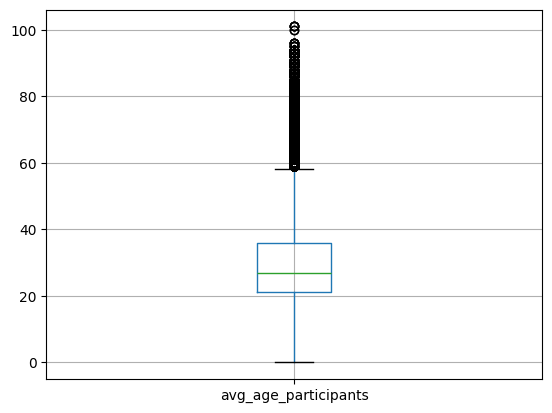

In [8]:
boxplot = dataset.boxplot(column = ['avg_age_participants'])
plt.show()

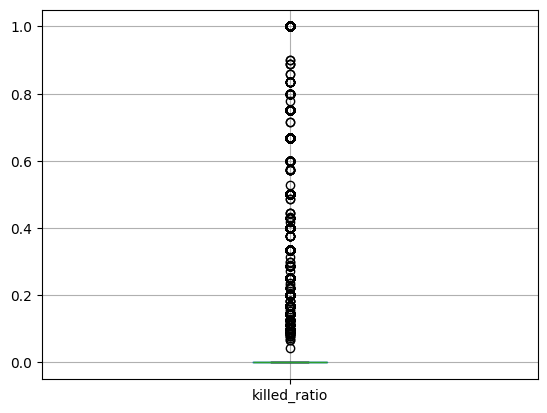

In [9]:
boxplot = dataset.boxplot(column = ['killed_ratio'])
plt.show()

Drop outliers for unrealistic values of avg age participants which may negatively influence clustering.

In [10]:
# Get whisker value of boxplot for avg_age_participants
lower_whisker_avg_age, upper_whisker_avg_age = return_whiskers(dataset, 'avg_age_participants')

# Drop rows with avg_age_participants > upper_whisker
dataset = dataset[dataset['avg_age_participants'] <= upper_whisker_avg_age]
print("Shape of dataset after removing outliers:", dataset.shape)

Shape of dataset after removing outliers: (230776, 74)


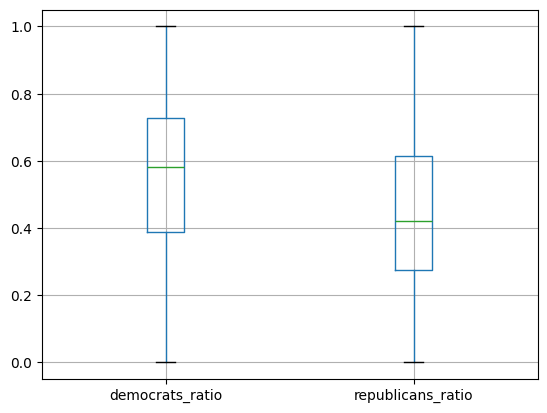

In [11]:
boxplot = dataset.boxplot(column = ['democrats_ratio', 'republicans_ratio'])
plt.show()

Values of 100% or 0% are pretty unrealistic, so we decide to drop all over 95% (or below 5%), considering them as outliers / wrongly observed data. Moreover, we will keep only one of the two ratios, and also drop the winning party attribute. For this reason, we decide to drop strange observations where the party that won had less than 50% of the votes.

In [12]:
print("Amount of reublicans_ratio outliers:", dataset[dataset['republicans_ratio'] == 1].shape[0] + dataset[dataset['republicans_ratio'] == 0].shape[0])
print("Amount of democrats_ratio outliers:", dataset[dataset['democrats_ratio'] == 1].shape[0] + dataset[dataset['democrats_ratio'] == 0].shape[0])

# Drop rows with republicans_ratio <= 0.05 or >= 0.95
dataset = dataset[(dataset['republicans_ratio'] > 0.05) & (dataset['republicans_ratio'] < 0.95)]
print("Shape of dataset after removing outliers:", dataset.shape)

Amount of reublicans_ratio outliers: 7372
Amount of democrats_ratio outliers: 7372
Shape of dataset after removing outliers: (218335, 74)


In [13]:
# Check how many times a party won and the percentage of votes for that part was <0.5
democrats_strange = len(dataset[(dataset['republicans_ratio'] > 0.5 ) & (dataset['party'] == 0)])
republicans_strange = len(dataset[(dataset['republicans_ratio'] < 0.5 ) & (dataset['party'] == 1)])

print("Amount of times democrats won and the percentage of votes for that part was <0.5:", democrats_strange)
print("Amount of times republicans won and the percentage of votes for that part was <0.5:", republicans_strange)
print("Amount of strange wins:", democrats_strange + republicans_strange)

# Drop rows with republican strange wins
dataset = dataset[((dataset['republicans_ratio'] > 0.5) & (dataset['party'] == 1)) | ((dataset['republicans_ratio'] < 0.5) & (dataset['party'] == 0))]
print("Shape of dataset after removing outliers:", dataset.shape)


Amount of times democrats won and the percentage of votes for that part was <0.5: 2959
Amount of times republicans won and the percentage of votes for that part was <0.5: 5712
Amount of strange wins: 8671
Shape of dataset after removing outliers: (209664, 74)


## 1.3 Dropping columns for different algorithms

In [14]:
dropped_columns = ['min_age_participants', 'max_age_participants', 'teen_ratio', 'totalvotes', 'year', 'party', 'democrats_ratio']
print("Attributes to drop:", dropped_columns)
dataset_reduced = dataset.drop(columns=dropped_columns, axis = 1)
print("Shape of dataset:", dataset_reduced.shape)

Attributes to drop: ['min_age_participants', 'max_age_participants', 'teen_ratio', 'totalvotes', 'year', 'party', 'democrats_ratio']
Shape of dataset: (209664, 67)


In [15]:
selected_state = "Florida"
dataset_reduced_florida = dataset_reduced[dataset_reduced["state_" + selected_state] == True]

In [16]:
dropped_columns = [c for c in dataset_reduced.columns if c.startswith('state_')]
print("Attributes to drop:", dropped_columns)

dataset_reduced = dataset_reduced.drop(columns=dropped_columns, axis = 1)
dataset_reduced_florida = dataset_reduced_florida.drop(columns=dropped_columns, axis = 1)

print("Shape of dataset:", dataset_reduced.shape)
print("Shape of dataset for florida:", dataset_reduced_florida.shape)

Attributes to drop: ['state_population', 'state_Alabama', 'state_Alaska', 'state_Arizona', 'state_Arkansas', 'state_California', 'state_Colorado', 'state_Connecticut', 'state_Delaware', 'state_District of Columbia', 'state_Florida', 'state_Georgia', 'state_Hawaii', 'state_Idaho', 'state_Illinois', 'state_Indiana', 'state_Iowa', 'state_Kansas', 'state_Kentucky', 'state_Louisiana', 'state_Maine', 'state_Maryland', 'state_Massachusetts', 'state_Michigan', 'state_Minnesota', 'state_Mississippi', 'state_Missouri', 'state_Montana', 'state_Nebraska', 'state_Nevada', 'state_New Hampshire', 'state_New Jersey', 'state_New Mexico', 'state_New York', 'state_North Carolina', 'state_North Dakota', 'state_Ohio', 'state_Oklahoma', 'state_Oregon', 'state_Pennsylvania', 'state_Rhode Island', 'state_South Carolina', 'state_South Dakota', 'state_Tennessee', 'state_Texas', 'state_Utah', 'state_Vermont', 'state_Virginia', 'state_Washington', 'state_West Virginia', 'state_Wisconsin', 'state_Wyoming']
Shape o

## 1.4 Scaling

In [17]:
scaler = MinMaxScaler()
scaled_dataset = scaler.fit_transform(dataset_reduced.values)

scaler_florida= MinMaxScaler()
scaled_dataset_florida = scaler_florida.fit_transform(dataset_reduced_florida.values)

print("Shape of scaled dataset:", scaled_dataset.shape)
print("Shape of scaled dataset for florida:", scaled_dataset_florida.shape)

Shape of scaled dataset: (209664, 15)
Shape of scaled dataset for florida: (13262, 15)


# 2. K Means

## 2.1 Identification of the best value of k

In [18]:
sse_list = []
silhouette_list = []
davies_bouldin_list = []

max_k = 20
for k in tqdm(range(2, max_k + 1), ):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(scaled_dataset)

    sse_list.append(kmeans.inertia_)
    silhouette_list.append(silhouette_score(scaled_dataset, kmeans.labels_, sample_size=10000))
    davies_bouldin_list.append(davies_bouldin_score(scaled_dataset, kmeans.labels_))

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:53<00:00,  2.79s/it]


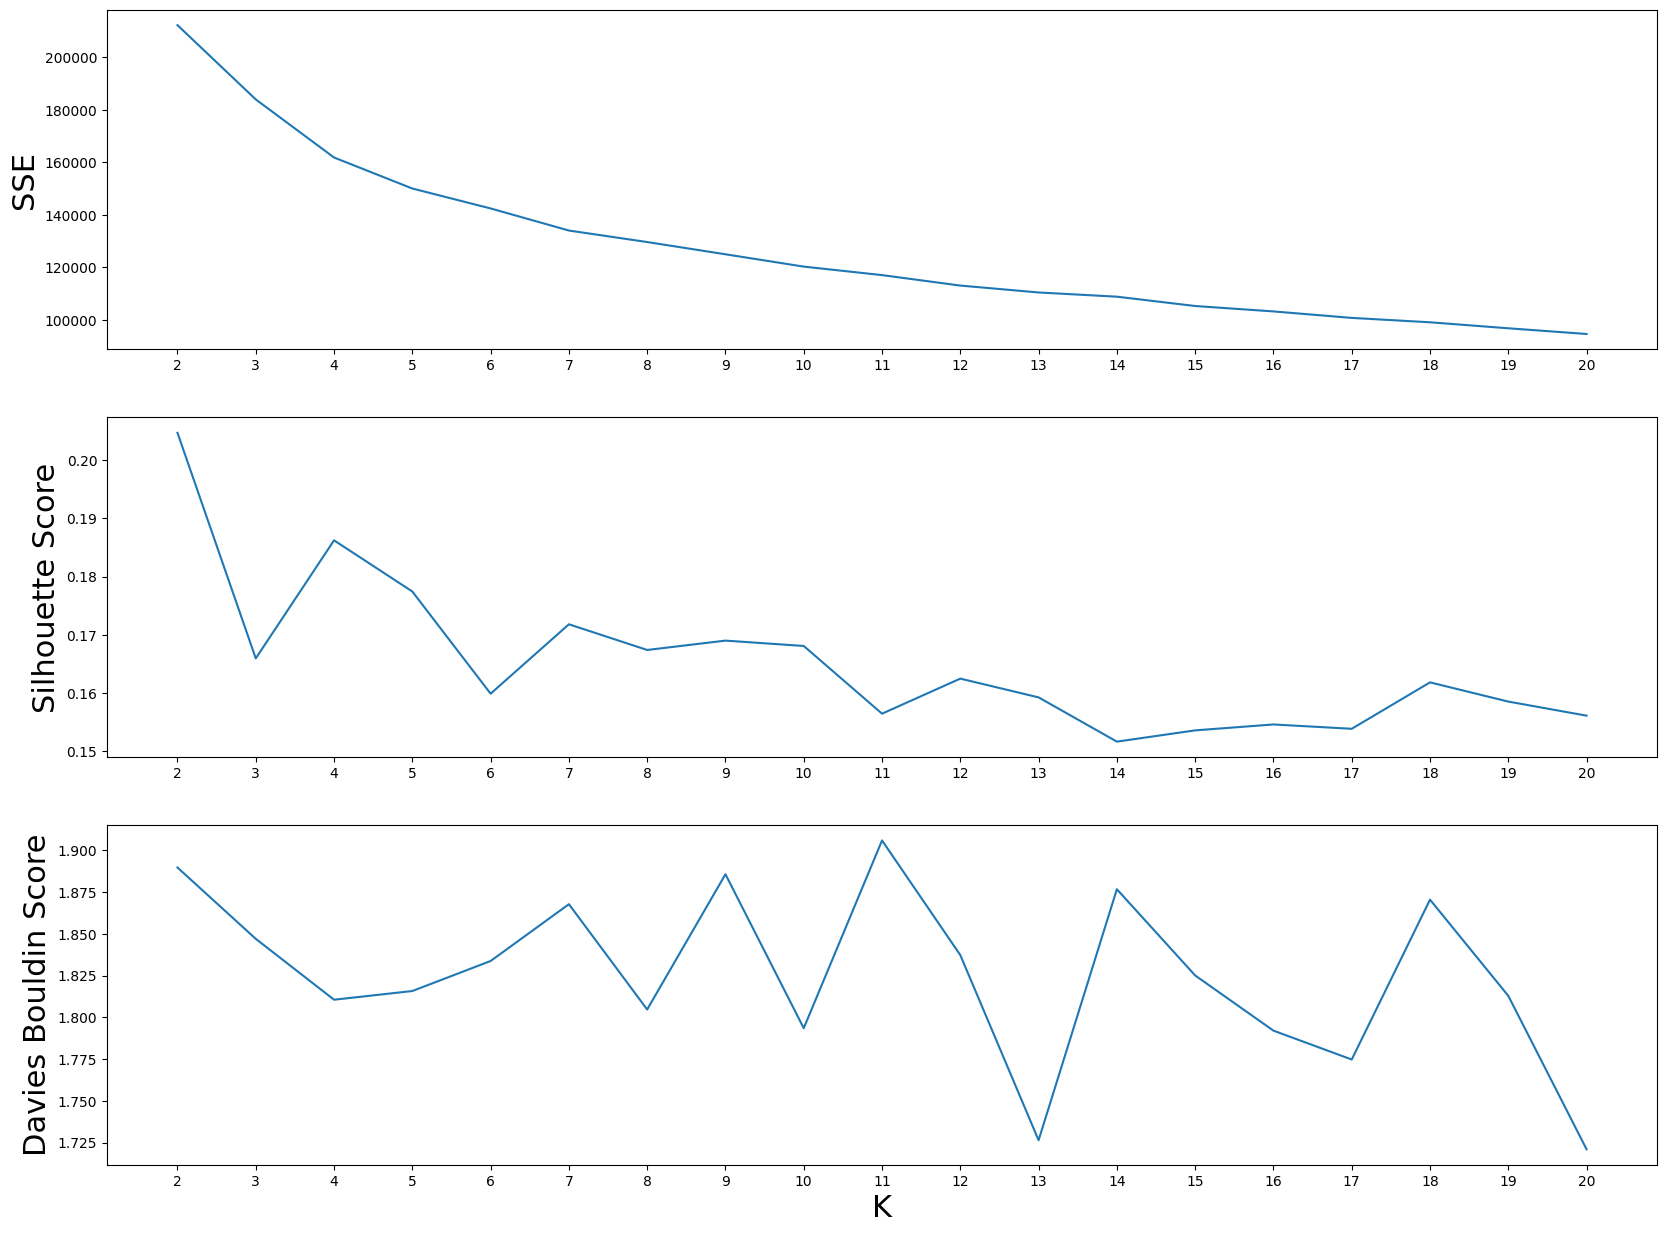

In [19]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list) + 2), sse_list)
ax[0].set_ylabel('SSE', fontsize=22)
ax[0].set_xticks(range(2, len(sse_list) + 2))

ax[1].plot(range(2, len(silhouette_list) + 2), silhouette_list)
ax[1].set_ylabel('Silhouette Score', fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list) + 2))

ax[2].plot(range(2, len(davies_bouldin_list) + 2), davies_bouldin_list)
ax[2].set_ylabel('Davies Bouldin Score', fontsize=22)
ax[2].set_xticks(range(2, len(davies_bouldin_list) + 2))


plt.xlabel('K', fontsize=22)
plt.show()

# NICER PLOTS

## 2.2 Analysis of the centroids and clusters

In [20]:
n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
kmeans.fit(scaled_dataset)

KMeans(n_clusters=9, n_init=10)

In [21]:
print("Shape of scaled_dataset: ", scaled_dataset.shape)
print("Shape of kmeans.labels_: ", kmeans.labels_.shape)
print("Shape of kmeans.cluster_centers_: ", kmeans.cluster_centers_.shape)

Shape of scaled_dataset:  (209664, 15)
Shape of kmeans.labels_:  (209664,)
Shape of kmeans.cluster_centers_:  (9, 15)


In [22]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=dataset_reduced.columns)
centers_df.head(7)

,date,populous_city,latitude,longitude,avg_age_participants,adults_ratio,males_ratio,killed_ratio,injured_ratio,arrested_ratio,n_participants,povertyPercentage,republicans_ratio,month_x,month_y
0,1039.095074,-6.494805e-15,36.986565,-92.333350,31.166083,0.933654,0.879614,0.977502,0.003407,0.005105,1.343742,12.844980,0.467603,0.022415,0.043161
1,939.147802,-7.382983e-15,37.099225,-89.183164,29.111042,0.922847,0.873775,0.112867,0.111624,0.138626,2.222845,13.076992,0.501985,0.656045,-0.224045
2,1004.748488,-6.938894e-15,37.549155,-88.103635,27.563185,0.887750,0.876766,0.014428,0.886289,0.036461,1.646219,12.707554,0.448974,-0.456060,-0.529962
3,1016.143109,1.000000e+00,38.834618,-87.746226,27.101367,0.888445,0.884486,0.007254,0.882956,0.003427,1.602227,11.901685,0.285125,-0.023434,-0.060152
4,1208.531501,-5.273559e-16,38.431404,-90.544951,28.953338,0.910875,0.913591,0.016768,0.009442,0.962622,1.666124,11.946884,0.503606,0.067380,0.061541
5,852.117174,-7.438494e-15,37.292601,-89.463222,29.318392,0.927842,0.879765,0.112583,0.113714,0.142706,2.271207,13.141895,0.502319,-0.697117,0.123751
6,1007.696232,1.000000e+00,37.291324,-90.969550,30.001679,0.945757,0.907278,0.861248,0.045091,0.003688,1.492285,12.321633,0.307861,0.006253,-0.020208


In [23]:
cluster_num_points = []
cluster_points = []
for i in range(n_clusters):
    cluster_points.append(scaled_dataset[kmeans.labels_ == i])
    cluster_num_points.append(len(cluster_points[-1]))
    
cluster_num_points, cluster_points[0].shape

([18583, 28844, 22828, 23261, 35645, 29244, 9527, 18679, 23053], (18583, 15))

In [24]:
kmeans_tot = KMeans(n_clusters=1, n_init=10)
kmeans_tot.fit(scaled_dataset)
total_SSE = kmeans_tot.inertia_ / len(scaled_dataset)

cluster_SSE = []
for i in range(n_clusters):
    cluster_sse = 0
    for point in cluster_points[i]:
        cluster_sse += np.linalg.norm(point - kmeans.cluster_centers_[i])**2
    cluster_SSE.append(cluster_sse / cluster_num_points[i])

print("Cluster SSE: ", cluster_SSE)
print("Total SSE: ", total_SSE)
print("SSE of cluster with min SSE: ", min(cluster_SSE))
print("SSE of cluster with max SSE: ", max(cluster_SSE))
print("Mean of SSE: ", np.mean(cluster_SSE))

Cluster SSE:  [0.6056500042748895, 0.5781130205984605, 0.5454692823206905, 0.6162393128547272, 0.5696679932783841, 0.5545345072878196, 0.5971513609236658, 0.7827724560793741, 0.5700713531644704]
Total SSE:  1.212051915638985
SSE of cluster with min SSE:  0.5454692823206905
SSE of cluster with max SSE:  0.7827724560793741
Mean of SSE:  0.602185476753609


In [25]:
cluster_distance_variance = []
total_distance_variance = 0
dataset_centroid = np.mean(scaled_dataset, axis=0)

###### CI RIPENSIAMO SU QUESTO ######
for point in scaled_dataset:
    total_distance_variance += (np.linalg.norm(point - dataset_centroid)**2 - total_SSE) ** 2
total_distance_variance /= len(scaled_dataset)
#####################################

for i in range(n_clusters):
    variance = 0
    for p in cluster_points[i]:
        variance += ((np.linalg.norm(p - kmeans.cluster_centers_[i]))**2 - cluster_SSE[i])**2
    cluster_distance_variance.append(variance/cluster_num_points[i])

print("Cluster distance variance: ", cluster_distance_variance)
print("Total distance variance: ", total_distance_variance)
print("Distance variance of cluster with min SSE: ", min(cluster_distance_variance))
print("Distance variance of cluster with max SSE: ", max(cluster_distance_variance))
print("Mean of distance variance: ", np.mean(cluster_distance_variance))

Cluster distance variance:  [0.09836810818559069, 0.08254679781644066, 0.12007961421401848, 0.11401302348086513, 0.09314490848265848, 0.07880263094256292, 0.08407079485426124, 0.0899893152203473, 0.11609295114529224]
Total distance variance:  0.21139288903173795
Distance variance of cluster with min SSE:  0.07880263094256292
Distance variance of cluster with max SSE:  0.12007961421401848
Mean of distance variance:  0.09745646048244856


Construct a distance matrix among cluster centroids.

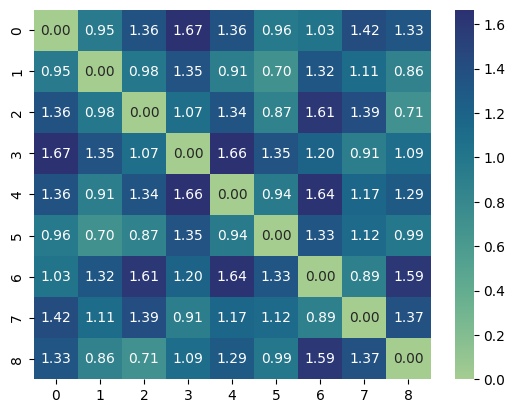

In [26]:
centroid_distance_matrix = squareform(pdist(kmeans.cluster_centers_))
sns.heatmap(centroid_distance_matrix, annot=True, fmt = '.2f', cmap='crest')
plt.show()

Construct matrix displaying correlation of attribute values to belonging to a certain cluster.

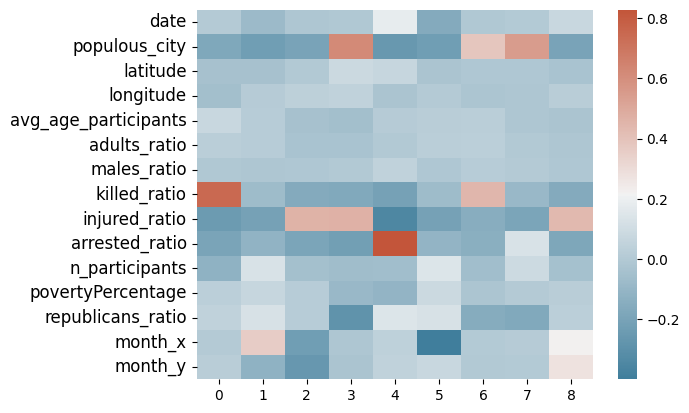

In [27]:
# Transfrom kmeans labels into onehot encoding
onehot = np.zeros((len(kmeans.labels_), n_clusters))
onehot[np.arange(len(kmeans.labels_)), kmeans.labels_] = 1

# Compute correlation between onehot encoding and scaled dataset
onehot_corr = np.corrcoef(scaled_dataset, onehot, rowvar=False)

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(onehot_corr[:scaled_dataset.shape[1], scaled_dataset.shape[1]:], cmap=cmap)

# Set ticks on y axis with feature names
plt.yticks(np.arange(scaled_dataset.shape[1]) + 0.5, dataset_reduced.columns, rotation=0, fontsize=12)
plt.show()

Compute the similarity matrix of a sample of the dataset.

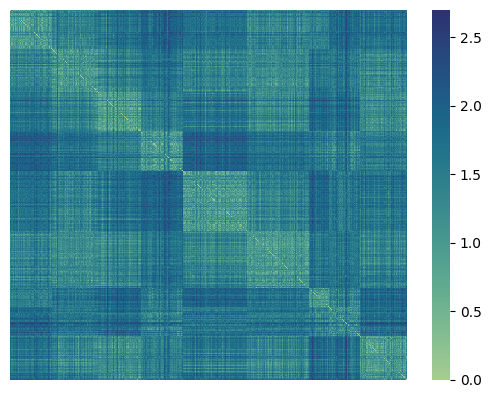

In [28]:
# Downsample the dataset to 10000
samples = np.random.choice(scaled_dataset.shape[0], 1000, replace=False)
downsampled_dataset = scaled_dataset[samples]
downsampled_labels = kmeans.labels_[samples]

# Sort based on labels
sorted_indexes = np.argsort(downsampled_labels)
downsampled_dataset = downsampled_dataset[sorted_indexes]
downsampled_labels = downsampled_labels[sorted_indexes]

# Compute similarity matrix
pdist_matrix = squareform(pdist(downsampled_dataset, metric='minkowski', p=2))
sns.heatmap(pdist_matrix, fmt = '.2f', cmap='crest')
plt.xticks([])
plt.yticks([])
plt.show()

In [29]:
kmeans.cluster_centers_.shape

(9, 15)

In [30]:
tsne = TSNE(n_components=2, n_jobs=-1)
tsne_dataset = np.concatenate((downsampled_dataset, kmeans.cluster_centers_))
tsne_labels = np.concatenate((downsampled_labels, range(n_clusters)))
tsne_map = tsne.fit_transform(tsne_dataset)

scatter = plt.scatter(tsne_map[:-n_clusters, 0], tsne_map[:-n_clusters, 1], c = tsne_labels[:-n_clusters], s=10, cmap='tab10')
plt.scatter(tsne_map[-n_clusters:, 0], tsne_map[-n_clusters:, 1], c = tsne_labels[-n_clusters:], s=100, cmap='tab10', marker='*', edgecolors='black')

#for i in range(n_clusters):
#    plt.annotate(i, tsne_map[-n_clusters + i, :], fontsize=20)

# Get unique cluster labels
unique_labels = set(tsne_labels[:-n_clusters])

# Create a legend with a color for each cluster
legend_entries = []
for label in unique_labels:
    # Find the indices of data points with the current label
    indices = tsne_labels[:-n_clusters] == label
    # Add a legend entry for the current label with the corresponding color
    legend_entries.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8, label=f'Cluster {label}'))

# Add legend to the plot
plt.legend(handles=legend_entries, loc='lower right')
plt.xlim(-50,100)
plt.show()

KeyboardInterrupt: 

## 2.3 Distribution of variables: within clusters vs whole dataset

Analysis of distribution of repubblican vs democrats in the clusters.

In [ ]:
party_xt_pct = pd.crosstab(kmeans.labels_, dataset_reduced['republicans_ratio'] > 0.5)
party_xt_pct

republicans_ratio,False,True
row_0,,
0,13373,15682
1,21542,1719
2,9253,11790
3,10576,12608
4,14268,16630
5,20350,14869
6,8486,1041
7,15937,2742
8,9879,8919


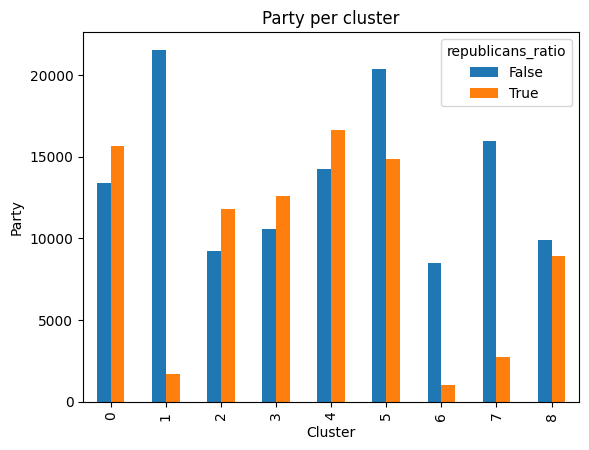

In [ ]:
party_xt_pct.plot(kind='bar', stacked=False, 
                   title='Party per cluster')
plt.xlabel('Cluster')
plt.ylabel('Party')
plt.show()

In [ ]:

populous_city_xt_pct = pd.crosstab(kmeans.labels_, dataset_reduced['populous_city'])
populous_city_xt_pct

populous_city,0,1
row_0,,
0,29055,0
1,0,23261
2,21043,0
3,23184,0
4,30898,0
5,35219,0
6,0,9527
7,0,18679
8,18798,0


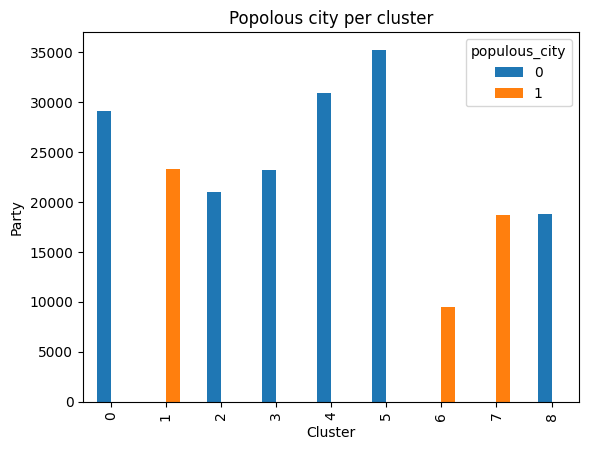

In [ ]:
populous_city_xt_pct.plot(kind='bar', stacked=False, 
                   title='Popolous city per cluster')
plt.xlabel('Cluster')
plt.ylabel('Party')
plt.show()

Let's explore some continuous variables, such as the arrested ratio, and look at clusters positively and negatively correlated to that variable. We can see that the distributions are very different amongst the two clusters, and they represent different trends which are present in the full distribution.

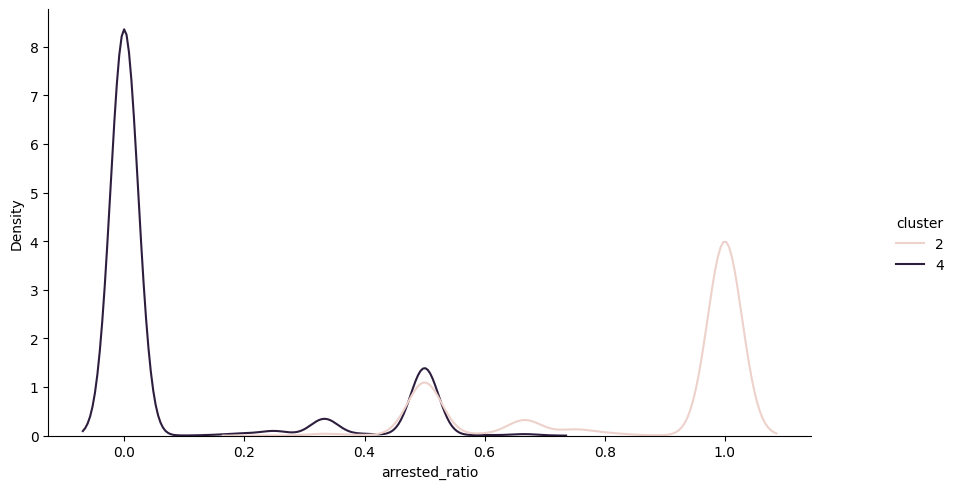

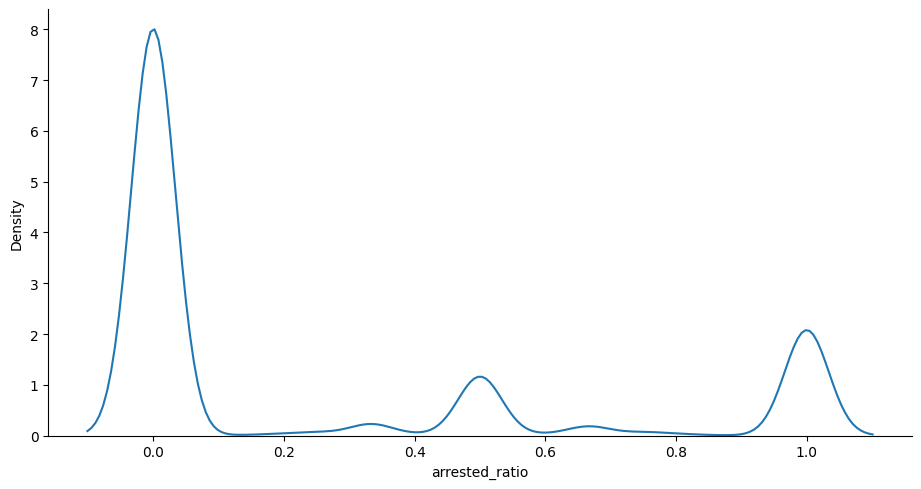

In [ ]:
# Plot distribution of average age for whole dataset and clusters
dataset_reduced_with_clusters = dataset_reduced.copy()
dataset_reduced_with_clusters['cluster'] = kmeans.labels_
dataset_reduced_with_clusters_3_4 = dataset_reduced_with_clusters[(dataset_reduced_with_clusters['cluster'] == 3) | \
                                                              (dataset_reduced_with_clusters['cluster'] == 4) ]  

sns.displot(dataset_reduced_with_clusters_3_4, x="arrested_ratio", kind='kde', hue="cluster")
plt.gcf().set_size_inches(10, 5)

sns.displot(dataset_reduced_with_clusters, x="arrested_ratio", kind='kde')
plt.gcf().set_size_inches(10, 5)
plt.show()


# 3. DBSCAN

## 3.1 Identification of best eps value

In [ ]:
k = 3
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree', n_jobs=-1).fit(scaled_dataset_florida)
distances, indices = nbrs.kneighbors(scaled_dataset_florida)
kth_distances = distances[:, k]
distances.shape

(13262, 4)

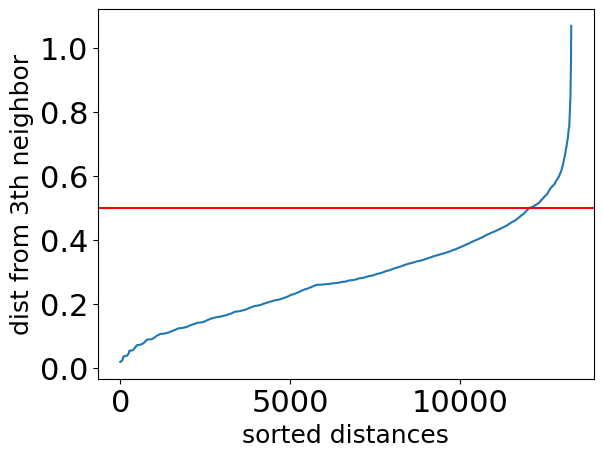

In [ ]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.axhline(y = 0.5, color = 'r')
plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
plt.xlabel('sorted distances', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

## 3.2 Cluster Analysis

In [ ]:
dbscan = DBSCAN(eps=0.43, min_samples=150)
dbscan.fit(scaled_dataset_florida)
labels, cluster_num_points = np.unique(dbscan.labels_, return_counts=True)
n_clusters = len(labels)
cluster_num_points

In [ ]:
cluster_points = []
for i in range(n_clusters):
    cluster_points.append(scaled_dataset_florida[dbscan.labels_ == i-1])

In [ ]:
print('Silhouette %s' % silhouette_score(scaled_dataset_florida, dbscan.labels_))
print('Davies-Bouldin %s' % davies_bouldin_score(scaled_dataset_florida, dbscan.labels_))

In [ ]:
# Transfrom kmeans labels into onehot encoding
onehot = np.zeros((len(dbscan.labels_), n_clusters))
onehot[np.arange(len(dbscan.labels_)), dbscan.labels_] = 1

# Compute correlation between onehot encoding and scaled dataset
onehot_corr = np.corrcoef(scaled_dataset_florida, onehot, rowvar=False)

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(onehot_corr[:scaled_dataset_florida.shape[1], scaled_dataset_florida.shape[1]:], fmt = '.2f', cmap=cmap)

# Set ticks on y axis with feature names
plt.yticks(np.arange(scaled_dataset_florida.shape[1]) + 0.5, dataset_reduced_florida.columns, rotation=0, fontsize=12)
[]

In [ ]:
# Downsample the dataset to 10000
samples = np.random.choice(scaled_dataset_florida.shape[0], 1000, replace=False)
downsampled_dataset = scaled_dataset_florida[samples]
downsampled_labels = dbscan.labels_[samples]

# Sort based on labels
sorted_indexes = np.argsort(downsampled_labels)
downsampled_dataset = downsampled_dataset[sorted_indexes]
downsampled_labels = downsampled_labels[sorted_indexes]

# Compute similarity matrix
pdist_matrix = squareform(pdist(downsampled_dataset, metric='minkowski', p=2))
sns.heatmap(pdist_matrix, fmt = '.2f', cmap='crest')
plt.xticks([])
plt.yticks([])

In [ ]:
tsne = TSNE(n_components=2, n_jobs=-1)
tsne_dataset = tsne.fit_transform(scaled_dataset_florida)

In [ ]:
colors = ['gray', 'red', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'brown']
for i in range(n_clusters):
    plt.scatter(tsne_dataset[:,0][dbscan.labels_ == i-1], tsne_dataset[:,1][dbscan.labels_ == i-1], s=3, c=colors[i])
plt.show()

In [ ]:
umap_reducer = UMAP().fit(scaled_dataset_florida)


In [ ]:
umap_dataset = umap_reducer.transform(scaled_dataset)
for i in range(n_clusters):
    plt.scatter(umap_dataset[:,0][dbscan.labels_ == i-1], umap_dataset[:,1][dbscan.labels_ == i-1], s=3, c=colors[i])
plt.show()

In [ ]:
for i in range(n_clusters):
    plt.scatter(dataset_reduced_florida["longitude"][dbscan.labels_ == i-1], dataset_reduced_florida["latitude"][dbscan.labels_ == i-1], s=10)

plt.xlim(-88, -78)
plt.ylim(26, 36)
plt.show()

## 3.3 Distribution of variables: within clusters vs whole dataset